## Topic Modeling for customer complaints
- I used a LDA topic modeling technique to see what customer complained about by using the negative review texts

In [4]:
#importing required libraries

import re

import numpy as np
import pandas as pd

from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils, models, utils

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy

import pyLDAvis
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [6]:
col_names = ['sentiment','title','review']
df = pd.read_csv("Amazon Dataset/train.csv", names = col_names)
df.head()

,sentiment,title,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [7]:
df = df[df['sentiment'] == 1] # only filter down negative reviews
df.head()

,sentiment,title,review
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
5,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...
6,1,Incorrect Disc,"I love the style of this, but after a couple y..."
7,1,DVD menu select problems,I cannot scroll through a DVD menu that is set...
9,1,"Not an ""ultimate guide""","Firstly,I enjoyed the format and tone of the b..."


## EDA & Test Preprocessing

In [8]:
df = df['review']
df.isna().sum()

0

In [9]:
df.duplicated().sum()

54

In [10]:
df.drop_duplicates(inplace = True)

In [11]:
df.duplicated().sum()

0

In [12]:
df = df.sample(frac = 0.03)
df.shape

(5998,)

In [13]:
stopwords = stopwords.words("english")
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(df)
print (lemmatized_texts[0][0:90])

paper bad then just grab plain ink jet paper print photo buy waste money photo print smudg


In [15]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['paper', 'bad', 'then', 'just', 'grab', 'plain', 'ink', 'jet', 'paper', 'print', 'photo', 'buy', 'waste', 'money', 'photo', 'print', 'smudge', 'bleed']


In [16]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 2), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1)]
bad


### Base LDA model

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [18]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(17,
  '0.092*"not" + 0.080*"be" + 0.049*"disappointing" + 0.048*"model" + '
  '0.032*"twice" + 0.024*"warm" + 0.023*"that" + 0.017*"appreciate" + '
  '0.015*"technical" + 0.015*"mother"'),
 (8,
  '0.050*"series" + 0.047*"paper" + 0.034*"disappointment" + 0.033*"print" + '
  '0.026*"shame" + 0.020*"ink" + 0.018*"plain" + 0.017*"pathetic" + '
  '0.014*"theory" + 0.014*"jump"'),
 (24,
  '0.140*"dvd" + 0.048*"disc" + 0.046*"release" + 0.024*"disk" + 0.019*"pull" '
  '+ 0.018*"post" + 0.018*"image" + 0.017*"edition" + 0.016*"online" + '
  '0.016*"originally"'),
 (23,
  '0.061*"base" + 0.043*"full" + 0.038*"follow" + 0.036*"text" + 0.031*"stuff" '
  '+ 0.020*"immediately" + 0.019*"dollar" + 0.017*"describe" + '
  '0.016*"cardboard" + 0.015*"hardly"'),
 (29,
  '0.102*"turn" + 0.028*"tape" + 0.028*"test" + 0.026*"buck" + 0.025*"cause" + '
  '0.025*"dry" + 0.023*"deal" + 0.019*"matter" + 0.019*"leg" + 0.019*"area"'),
 (5,
  '0.087*"video" + 0.047*"nice" + 0.038*"true" + 0.035*"mind" + 0.034*"

In [19]:
import pyLDAvis.gensim_models
import pyLDAvis

#visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

pyLDAvis.display(LDAvis_prepared)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [20]:
# Compute Model Perplexity and coherence score
from gensim.models import CoherenceModel

#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words,
                                    dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3813597639255261


### Futher Development with followings:
- TFIDF
- Trigrams 

In [21]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['paper', 'bad', 'then', 'just', 'grab', 'plain', 'ink', 'jet', 'paper', 'print', 'photo', 'buy', 'waste', 'money', 'photo', 'print', 'smudge', 'bleed']


In [22]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [23]:
tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.1
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
  bow = corpus[i]
  low_value_words = []
  tfidf_ids = [id for id, value in tfidf[bow]]
  bow_ids = [id for id, value in bow]
  low_value_words = [id for id, value in tfidf[bow] if value < low_value]
  drops = low_value_words+words_missing_in_tfidf 

  for item in drops:
    words.append(id2word[item])
  words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
  corpus[i] = new_bow

In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [25]:
#visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

pyLDAvis.display(LDAvis_prepared)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, 
                                                        start=10, limit=36, step=2)

Text(0, 0.5, 'Coherence score')

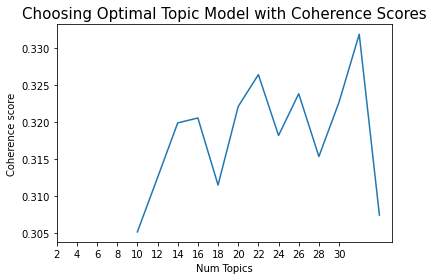

In [28]:
# Show graph
start=10; limit=36; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Choosing Optimal Topic Model with Coherence Scores", size=15)
plt.xticks(np.arange(2,32,step=2))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")


In [29]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]

#select the model and print the topics
# model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \
of {coherence_values[best_result_index]}''')

The 32 topics gives the highest coherence score of 0.3318446059070591


In [30]:
# Final Model

final_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word, 
                                              num_topics=32, 
                                              random_state=100, 
                                              update_every=1,
                                              chunksize=100,
                                              passes=10,
                                              alpha='auto',
                                              per_word_topics=True

)


In [31]:
#visualize the topics
pyLDAvis.enable_notebook()
final_viz = pyLDAvis.gensim_models.prepare(final_model, corpus, id2word, mds="mmds", R=30)

pyLDAvis.display(final_viz)


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [32]:
pprint(final_model.print_topics())

[(15,
  '0.114*"game" + 0.102*"play" + 0.061*"love" + 0.044*"come" + 0.033*"girl" + '
  '0.028*"baby" + 0.017*"ruin" + 0.014*"parent" + 0.012*"while" + '
  '0.011*"fully"'),
 (29,
  '0.097*"will" + 0.078*"order" + 0.054*"tell" + 0.049*"version" + '
  '0.031*"finish" + 0.030*"release" + 0.030*"include" + 0.029*"sell" + '
  '0.027*"color" + 0.026*"suppose"'),
 (10,
  '0.069*"write" + 0.028*"chapter" + 0.026*"already" + 0.022*"opinion" + '
  '0.020*"performance" + 0.020*"often" + 0.019*"press" + 0.018*"kill" + '
  '0.017*"mind" + 0.016*"switch"'),
 (28,
  '0.075*"thing" + 0.060*"when" + 0.052*"star" + 0.051*"little" + '
  '0.045*"enough" + 0.044*"plastic" + 0.042*"cheap" + 0.036*"case" + '
  '0.030*"pretty" + 0.029*"description"'),
 (4,
  '0.062*"great" + 0.055*"should" + 0.048*"part" + 0.037*"do" + 0.035*"toy" + '
  '0.035*"water" + 0.027*"must" + 0.027*"always" + 0.027*"son" + '
  '0.024*"check"'),
 (2,
  '0.043*"now" + 0.029*"blade" + 0.026*"name" + 0.026*"change" + '
  '0.024*"probabl

### Visualization and Interpretation

In [55]:
# top 20 significant terms for each topic

topics=[]
for i in range(0,32):
    topic_list=[]
    for term, wt in final_model.show_topic(i, topn=20):
        topic_list.append((term, round(wt,3)))
    topics.append(topic_list)

In [56]:
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, final_model.num_topics+1)] )
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,Terms per Topic
Topic1,"dvd, use, quality, poor, day, player, software, better, daughter, spend, card, person, system, audio, gift, computer, trouble, speak, install, router"
Topic2,"return, send, back, problem, pay, wrong, fan, week, less, issue, next, hand, throw, simply, refund, around, avoid, couple, loose, dollar"
Topic3,"now, blade, name, change, probably, hole, allow, brand, face, admit, file, vacuum, advice, market, walk, flaw, laptop, garbage, workout, yr_old"
Topic4,"sound, why, few, open, scene, information, man, least, base, hope, word, different, episode, line, kid, smell, instead, true, season, learn"
Topic5,"great, should, part, do, toy, water, must, always, son, check, number, plug, night, bottom, direction, mess, properly, connect, bottle, push"
Topic6,"film, make, lot, plot, terrible, run, company, hate, bit, finally, sense, bother, consider, script, certainly, re, defective, search, favorite, ridiculous"
Topic7,"first, look, other, people, set, second, most, unit, low, fail, disappointing, mean, mix, mention, follow, weak, fat, barely, action, rock"
Topic8,"would, really, new, take, last, real, maybe, replace, point, right, size, long, hour, machine, reason, far, clean, definitely, single, wonder"
Topic9,"expect, still, purchase, try, disc, hold, full, metal, service, compare, out_there, expensive, available, lie, plain, perfect, glass, theory, no_longer, punch"
Topic10,"product, work, again, own, cost, minute, easily, stuff, remove, stand, burn, hair, fly, no, note, bunch, somewhat, suck, dark, cast"


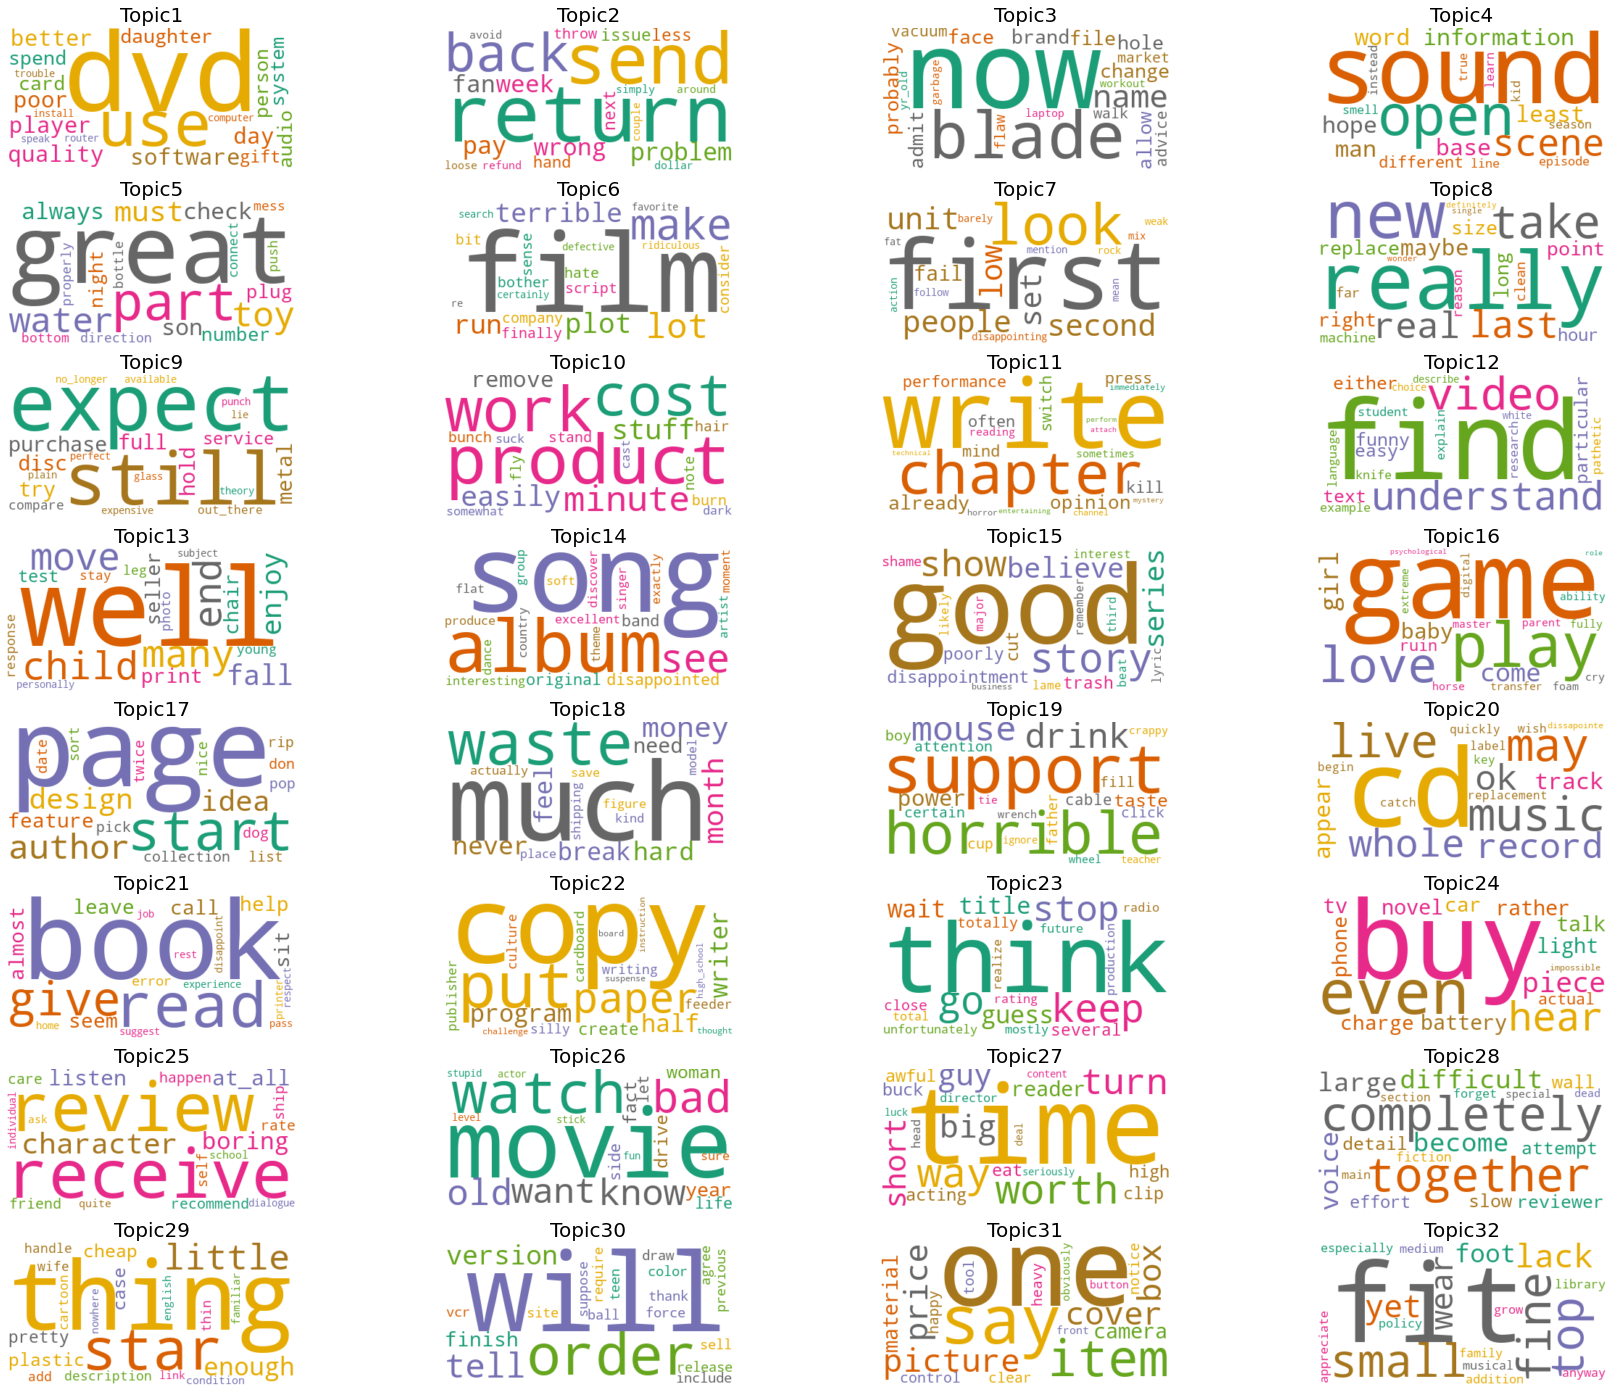

In [61]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [30, 25]

# Create subplots for each topic
for i in range(32):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(8, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i], size=20)

plt.show()

Future Studies

- One of down sides in this analysis was we do not know which product they purchased and disliked about. 
- Although it was useful to see all at once for what customer dislike about products they bought but we do not know which product they complaining about so it would be great to analyze text per product